# ***Cart ADASYN***

In [1]:
import os
import random
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm
import optuna
from optuna.pruners import MedianPruner
import optuna.visualization as vis
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, label_binarize, OrdinalEncoder
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss, roc_auc_score, roc_curve, auc
)
from imblearn.pipeline import Pipeline  
from imblearn.over_sampling import ADASYN
from sklearn.neighbors import NearestNeighbors
import time
import lime.lime_tabular
from sklearn.preprocessing import LabelEncoder

from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:

# =======================
# LOAD DATA
# =======================
file_path = "../Saber_pro_sampled_data.csv"
df = pd.read_csv(file_path)
#df = df.head(1000)
X = df.drop(columns=["MOD_INGLES_DESEM"])
y = df["MOD_INGLES_DESEM"]


In [3]:
le = LabelEncoder()
y = pd.Series(le.fit_transform(y), index=y.index)

class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class mapping:", class_mapping)

Class mapping: {'-A1': np.int64(0), 'A1': np.int64(1), 'A2': np.int64(2), 'B1': np.int64(3), 'B2': np.int64(4)}


In [4]:
df.shape

(102990, 22)

In [5]:
# =======================
# FILE PATHS
# =======================
model_filename = "../Models/best_decision_tree_model_ad.pkl"
study_filename = "../Study/optuna_study_tree_model_nested_ad.pkl"
metrics_filename = "../Metrics/best_decision_tree_metrics_ad.pkl"
fold_metrics_filename = "../Metrics/cart_folds_summary_ad.csv"

In [6]:
# =======================
# PIPELINE BUILDER
# =======================

# Explicitly ordered categorical columns
ORDINAL_COLUMNS = {
    'FAMI_ESTRATOVIVIENDA': [
        'Sin Estrato',
        'Estrato 1',
        'Estrato 2',
        'Estrato 3',
        'Estrato 4',
        'Estrato 5',
        'Estrato 6'
    ],

    'FAMI_EDUCACIONPADRE': [
        'Ninguno',
        'Primaria incompleta',
        'Primaria completa',
        'Secundaria (Bachillerato) incompleta',
        'Secundaria (Bachillerato) completa',
        'Técnica o tecnológica incompleta',
        'Técnica o tecnológica completa',
        'Educación profesional incompleta',
        'Educación profesional completa',
        'Postgrado',
        'No sabe',
        'No Aplica'
    ],

    'FAMI_EDUCACIONMADRE': [
        'Ninguno',
        'Primaria incompleta',
        'Primaria completa',
        'Secundaria (Bachillerato) incompleta',
        'Secundaria (Bachillerato) completa',
        'Técnica o tecnológica incompleta',
        'Técnica o tecnológica completa',
        'Educación profesional incompleta',
        'Educación profesional completa',
        'Postgrado',
        'No sabe',
        'No Aplica'
    ],

    'ESTU_HORASSEMANATRABAJA': [
        '0',
        'Menos de 10 horas',
        'Entre 11 y 20 horas',
        'Entre 21 y 30 horas',
        'Más de 30 horas'
    ],

    'ESTU_VALORMATRICULAUNIVERSIDAD': [
        "No pagó matrícula",
        "Menos de 500 mil",
        "Entre 500 mil y menos de 1 millón",
        "Entre 1 millón y menos de 2.5 millones",
        "Entre 2.5 millones y menos de 4 millones",
        "Entre 4 millones y menos de 5.5 millones",
        "Entre 5.5 millones y menos de 7 millones",
        "Más de 7 millones"
    ]
}


def build_pipeline(params: dict, X: pd.DataFrame = None) -> Pipeline:
    if X is None:
        raise ValueError("X must be provided to build the pipeline dynamically.")

    categorical_features = X.select_dtypes(include='object').columns.tolist()
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    ordinal_cols = [col for col in ORDINAL_COLUMNS if col in X.columns]
    nominal_cols = [col for col in categorical_features if col not in ordinal_cols]

    transformers = [('num', SimpleImputer(strategy='median'), numeric_features)]

    if nominal_cols:
        transformers.append(('ohe_cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Sin Dato')),
            ('ohe', OneHotEncoder(handle_unknown='ignore'))
        ]), nominal_cols))

    if ordinal_cols:
        for col in ordinal_cols:
            categories = [ORDINAL_COLUMNS[col]] if ORDINAL_COLUMNS[col] is not None else 'auto'
            transformers.append((f'ord_{col}', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='Sin Dato')),
                ('ord', OrdinalEncoder(categories=categories if categories != 'auto' else 'auto',
                                       handle_unknown='use_encoded_value', unknown_value=-1))
            ]), [col]))

    preprocessor = ColumnTransformer(
        transformers,
        remainder='drop',
        verbose_feature_names_out=False
    )

    sampler = ADASYN(random_state=SEED, n_neighbors=5, n_jobs=5)
    model = DecisionTreeClassifier(**params, random_state=SEED)

    return Pipeline([
        ('preprocessor', preprocessor),
        ('adasyn', sampler),
        ('classifier', model)
    ])


In [7]:
# =======================
# MODEL EVALUATION
# =======================
def evaluate_model(model: Pipeline, X_data: pd.DataFrame, y_data: pd.Series) -> tuple:
    """
    Returns evaluation metrics for a trained model on given data.
    """
    y_pred = model.predict(X_data)
    y_proba = model.predict_proba(X_data)
    f1 = f1_score(y_data, y_pred, average='weighted')
    acc = accuracy_score(y_data, y_pred)
    loss = log_loss(y_data, y_proba)
    auc = roc_auc_score(y_data, y_proba, multi_class='ovr', average='weighted')
    report = classification_report(y_data, y_pred)
    cm = confusion_matrix(y_data, y_pred)
    return f1, acc, loss, auc, report, cm, y_proba, y_pred

In [8]:

# =======================
# HYPERPARAMETER TUNING
# =======================
def run_inner_optuna(X_inner: pd.DataFrame, y_inner: pd.Series, n_trials: int = 50) -> tuple:
    """
    Inner CV loop using Optuna to optimize DecisionTree hyperparameters.
    """
    def objective(trial):
        params = {
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 30),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
            "ccp_alpha": trial.suggest_float("ccp_alpha", 1e-5, 1e-2, log=True),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 30, 100)
        }
        pipeline = build_pipeline(params, X_inner)
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
        scores = []
        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            pipeline.fit(X_t, y_t)
            y_pred = pipeline.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))
        return np.mean(scores)

    pruner = MedianPruner()
    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=n_trials)
    return study.best_params, study

In [9]:
# =======================
# FOLD METRIC SAVER
# =======================
def save_metrics_folds(folds_metrics: list, filename: str) -> pd.DataFrame:
    """
    Saves per-fold metrics + final rows for mean and std in a single CSV.
    Returns full DataFrame (raw + summary).
    """
    df = pd.DataFrame(folds_metrics)

    metric_cols = df.columns.drop('fold') if 'fold' in df.columns else df.columns
    mean_row = df[metric_cols].mean().to_dict()
    std_row = df[metric_cols].std().to_dict()

    mean_row['fold'] = 'mean'
    std_row['fold'] = 'std'

    df_final = pd.concat([df, pd.DataFrame([mean_row, std_row])], ignore_index=True)

    df_final.to_csv(filename, index=False)
    print(f"📁 Fold metrics + summary saved to: {filename}")
    return df_final

# =======================
# PLOT CONFUSION MATRIX
# =======================
def plot_confusion_matrix(cm, labels, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

In [10]:
# =======================
# LIME EXPLAINER BUILDER
# =======================
def get_lime_explainer(model_pipeline: Pipeline, X_train_raw: pd.DataFrame, y_train_raw: pd.Series):
    """
    Constructs LIME explainer using preprocessed training data.
    """
    X_transformed = model_pipeline.named_steps['preprocessor'].transform(X_train_raw)
    feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
    class_names = np.unique(y_train_raw).astype(str)
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_transformed,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )
    return explainer, X_transformed

In [11]:
def nested_cv(X: pd.DataFrame, y: pd.Series) -> tuple:
    """
    Executes nested CV with full metric tracking (train/val/test), including classification reports,
    confusion matrices and predict_proba for LIME. Also includes Optuna visualizations.
    """
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
            print("Loaded best model and metrics from disk.")
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
            fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    optuna_studies = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_f1 = -np.inf
    best_model = None
    best_metrics = {}

    for fold, (train_idx, test_idx) in tqdm(
        enumerate(outer_cv.split(X, y), 1),
        total=outer_cv.get_n_splits(),
        desc="Training folds"
    ):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        # Extra validation split for reporting
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_fold, y_train_fold,
            test_size=0.2,
            stratify=y_train_fold,
            random_state=SEED
        )

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr)
        optuna_time = time.time() - start_time
        optuna_studies.append(study)
        model = build_pipeline(best_params, X_tr)
        model.fit(X_tr, y_tr)

        # FULL train evaluation
        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = evaluate_model(model, X_tr, y_tr)

        # Validation evaluation
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = evaluate_model(model, X_val, y_val)

        # Outer test evaluation
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test,
            "optuna_time": optuna_time
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": model.named_steps['classifier'].classes_,
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename)
    joblib.dump({'studies': optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    df_folds = save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    # Visualizations for best study
    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)
    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
    fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
    visualizations['f1_score_evolution'] = fig

    return best_model, best_metrics, study_dt, visualizations

In [12]:
# Run pipeline
model, metrics, study, visualizations = nested_cv(X, y)

Loaded best model and metrics from disk.


In [13]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  []),
                                                 ('ohe_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Sin '
                                                                                            'Dato',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['FAMI_TIENEAUTOMOVIL',
                                                   'FAMI_TIENECOMPUTADOR',
                                                   'FAMI_TIENEINTERNET',
                                                   'FAMI_TIENELAVADORA',
                                                   'ESTU_NU...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['ESTU_VALORMATRICULAUNIVERSIDAD'])],
                                   verbose_feature_names_out=False)),
                ('adasyn', ADASYN(n_jobs=5, random_state=42)),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.0007531425994893288,
                                        criterion='entropy', max_depth=10,
                                        max_leaf_nodes=79, min_samples_leaf=7,
                                        min_samples_split=25,
                                        random_state=42))])

In [14]:
metrics.keys()

dict_keys(['fold', 'f1_train', 'accuracy_train', 'log_loss_train', 'auc_train', 'f1_val', 'accuracy_val', 'log_loss_val', 'auc_val', 'f1_test', 'accuracy_test', 'log_loss_test', 'auc_test', 'optuna_time', 'params', 'labels', 'best_fold', 'X_train_fold', 'y_train_fold', 'y_train_pred', 'y_train_true', 'y_proba_train', 'classification_report_train', 'confusion_matrix_train', 'y_val_true', 'y_val_pred', 'y_proba_val', 'classification_report_val', 'confusion_matrix_val', 'y_test_fold', 'y_test_pred', 'y_proba_test', 'classification_report_test', 'confusion_matrix_test'])

In [15]:
print(metrics['classification_report_train'])

              precision    recall  f1-score   support

           0       0.27      0.20      0.23      6090
           1       0.34      0.34      0.34     13827
           2       0.48      0.48      0.48     25076
           3       0.35      0.30      0.32     14340
           4       0.39      0.58      0.47      6580

    accuracy                           0.40     65913
   macro avg       0.36      0.38      0.37     65913
weighted avg       0.39      0.40      0.39     65913



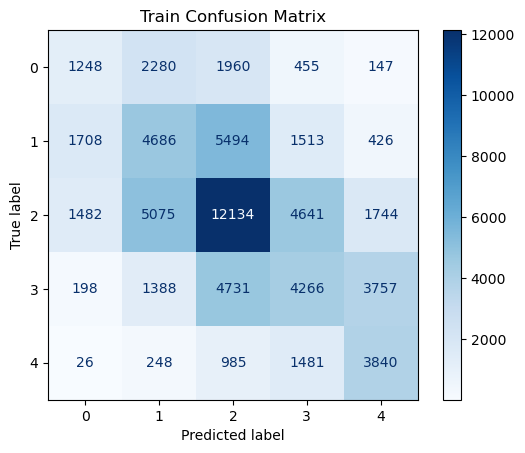

In [16]:
plot_confusion_matrix(metrics['confusion_matrix_train'], metrics['labels'], "Train Confusion Matrix")

In [17]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.26      0.20      0.23      1523
           1       0.33      0.32      0.33      3457
           2       0.48      0.48      0.48      6269
           3       0.34      0.30      0.32      3585
           4       0.39      0.58      0.47      1645

    accuracy                           0.39     16479
   macro avg       0.36      0.38      0.36     16479
weighted avg       0.39      0.39      0.39     16479



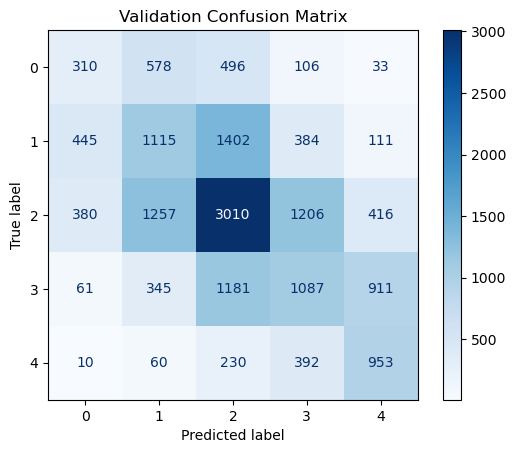

In [18]:
plot_confusion_matrix(metrics['confusion_matrix_val'], metrics['labels'], "Validation Confusion Matrix")

In [19]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.27      0.21      0.24      1903
           1       0.33      0.33      0.33      4321
           2       0.48      0.49      0.49      7836
           3       0.35      0.29      0.32      4482
           4       0.39      0.57      0.46      2056

    accuracy                           0.40     20598
   macro avg       0.36      0.38      0.37     20598
weighted avg       0.39      0.40      0.39     20598



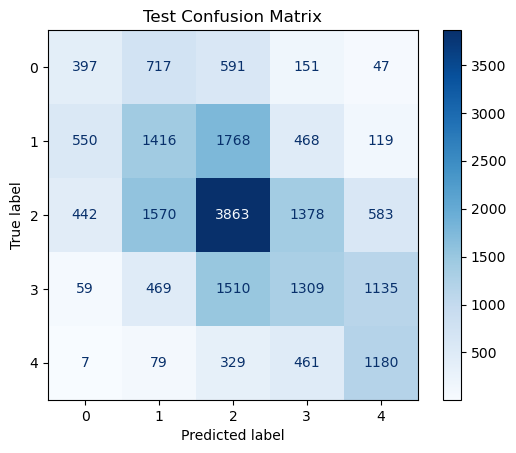

In [20]:
plot_confusion_matrix(metrics['confusion_matrix_test'], metrics['labels'], "Test Confusion Matrix")

In [21]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  []),
                                                 ('ohe_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Sin '
                                                                                            'Dato',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['FAMI_TIENEAUTOMOVIL',
                                                   'FAMI_TIENECOMPUTADOR',
                                                   'FAMI_TIENEINTERNET',
                                                   'FAMI_TIENELAVADORA',
                                                   'ESTU_NU...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['ESTU_VALORMATRICULAUNIVERSIDAD'])],
                                   verbose_feature_names_out=False)),
                ('adasyn', ADASYN(n_jobs=5, random_state=42)),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.0007531425994893288,
                                        criterion='entropy', max_depth=10,
                                        max_leaf_nodes=79, min_samples_leaf=7,
                                        min_samples_split=25,
                                        random_state=42))])

--- Explanation for class 0 ---


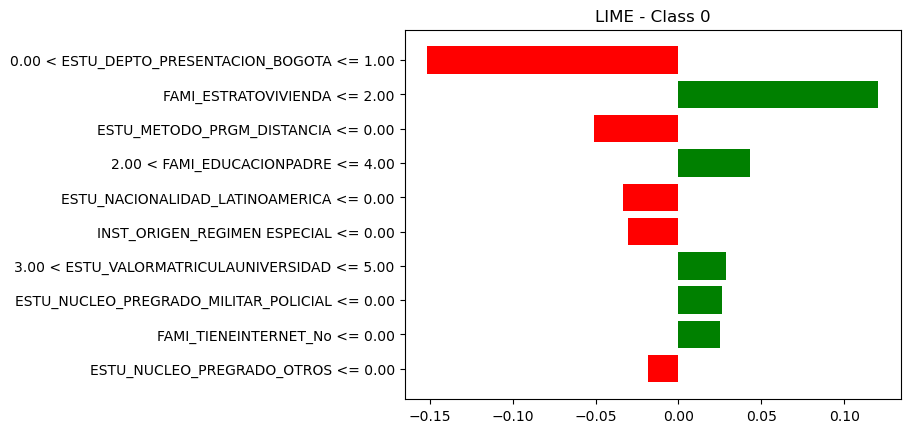

--- Explanation for class 1 ---


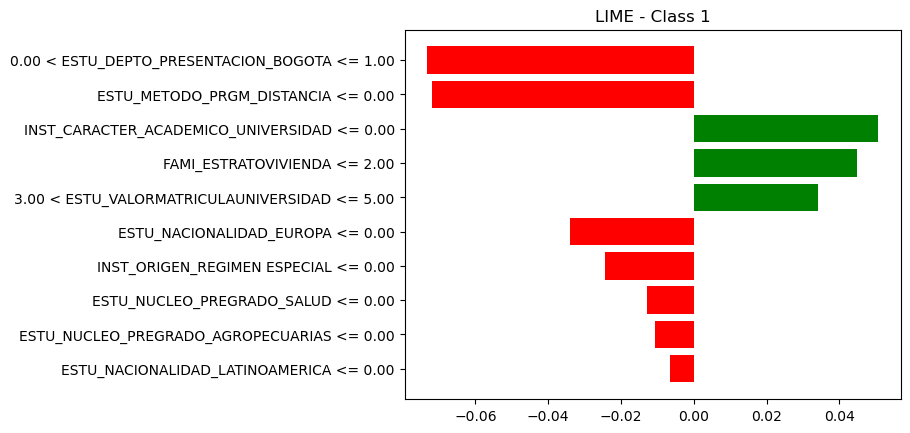

--- Explanation for class 2 ---


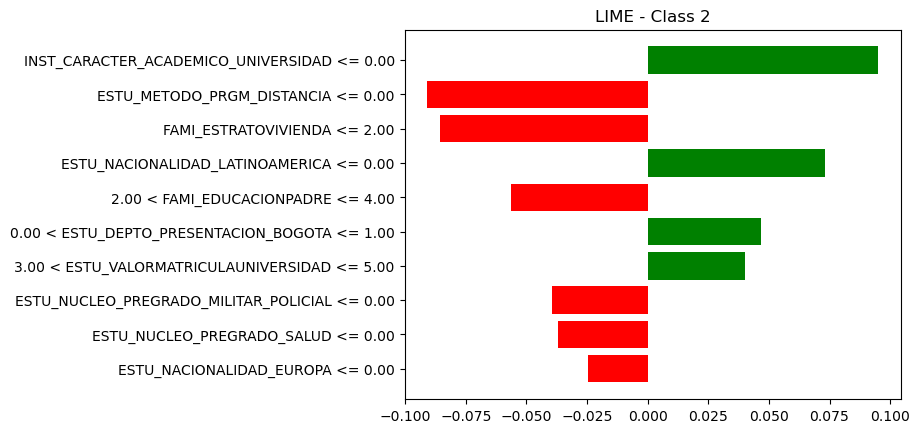

--- Explanation for class 3 ---


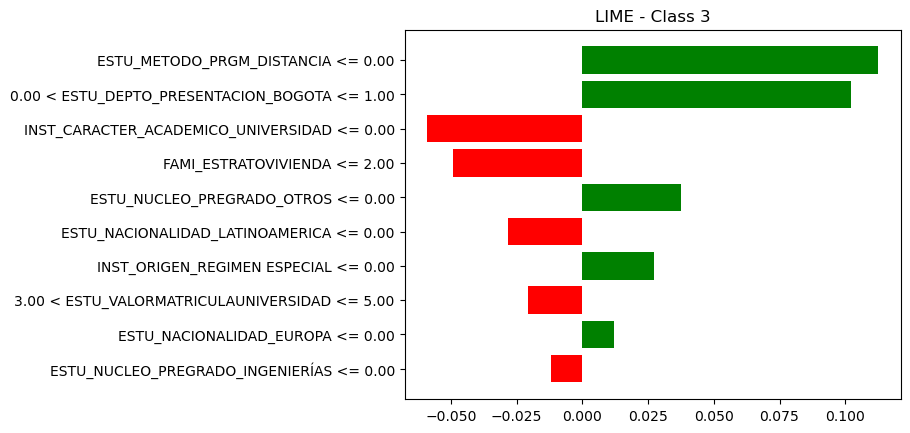

--- Explanation for class 4 ---


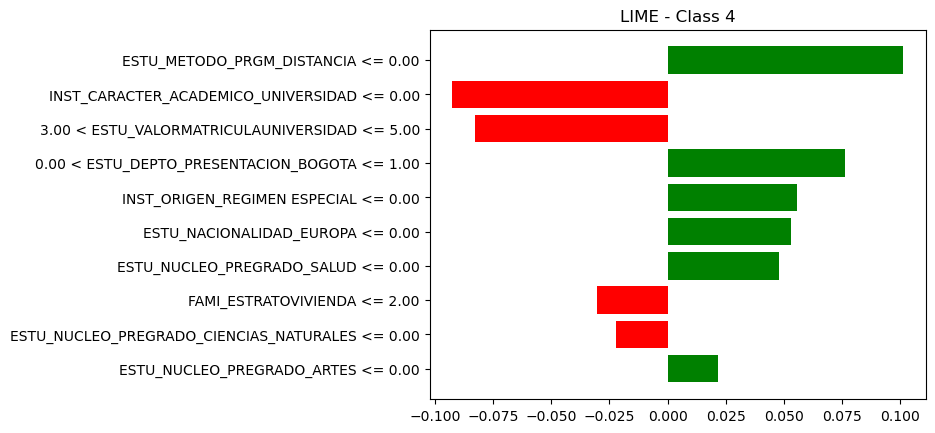

In [22]:
# Get LIME explainer and transformed data
explainer, X_transformed = get_lime_explainer(model, metrics['X_train_fold'], metrics['y_train_fold'])

# Extract raw classifier (without preprocessing)
clf = model.named_steps['classifier']

# Prediction function for LIME
predict_fn = lambda x: clf.predict_proba(x)

# Select transformed instance
instance = X_transformed[10]

# Explain prediction for all classes
#exp = explainer.explain_instance(instance, predict_fn=predict_fn, labels=[0, 1, 2])
exp = explainer.explain_instance(instance, predict_fn=predict_fn, labels=[0, 1, 2, 3, 4])

# Show explanation summary
exp.show_in_notebook(show_table=True)

# Plot per-class explanations
for class_label in exp.available_labels():
    print(f"--- Explanation for class {class_label} ---")
    fig = exp.as_pyplot_figure(label=class_label)
    plt.title(f"LIME - Class {class_label}")
    plt.show()



In [23]:
study

In [24]:
visualizations.keys()

dict_keys(['optimization_history', 'parallel_coordinate', 'param_importances', 'f1_score_evolution'])

In [25]:
visualizations['optimization_history']

In [26]:
visualizations['parallel_coordinate']

In [27]:
visualizations['f1_score_evolution']

In [28]:
visualizations['param_importances']

In [29]:
# Feature Importance Plot
importances = model.named_steps['classifier'].feature_importances_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

fig = px.bar(importance_df,
             x='Feature',
             y='Importance',
             title='Top 20 Feature Importance of the Decision Tree Model',
             labels={'Feature': 'Feature Name', 'Importance': 'Importance Score'},
             color='Importance',
             color_continuous_scale='Viridis',
             text='Importance')
fig.update_layout(xaxis_tickangle=45)
fig.show()

In [30]:
reporte.save(metrics, model_name="CART_ADASYN")


✅ Report for model 'CART_ADASYN' saved:
   → CSV: ../Metrics/Metrics_CART_ADASYN.csv
   → JSON: ../Metrics/Metrics_CART_ADASYN.json


In [31]:
df = reporte.load()


✅ Loaded 3 report(s):
   → Models: ['CART_SMOTE', 'CART_ADASYN', 'CART']
   → Types : ['train', 'val', 'test']


In [32]:
df.query("Model == 'CART_ADASYN' and Type == 'train' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
24,CART_ADASYN,train,0,0.268,0.205,0.232
25,CART_ADASYN,train,1,0.343,0.339,0.341
26,CART_ADASYN,train,2,0.48,0.484,0.482
27,CART_ADASYN,train,3,0.345,0.297,0.32
28,CART_ADASYN,train,4,0.387,0.584,0.466
29,CART_ADASYN,train,macro avg,0.364,0.382,0.368
30,CART_ADASYN,train,weighted avg,0.393,0.397,0.392


In [33]:
df.query("Model == 'CART_ADASYN' and Type == 'val' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
32,CART_ADASYN,val,0,0.257,0.204,0.227
33,CART_ADASYN,val,1,0.332,0.323,0.327
34,CART_ADASYN,val,2,0.476,0.48,0.478
35,CART_ADASYN,val,3,0.342,0.303,0.322
36,CART_ADASYN,val,4,0.393,0.579,0.468
37,CART_ADASYN,val,macro avg,0.36,0.378,0.365
38,CART_ADASYN,val,weighted avg,0.388,0.393,0.388


In [34]:
df.query("Model == 'CART_ADASYN' and Type == 'test' and Class != 'global'").iloc[:, 0:6]


,Model,Type,Class,precision,recall,f1-score
40,CART_ADASYN,test,0,0.273,0.209,0.236
41,CART_ADASYN,test,1,0.333,0.328,0.33
42,CART_ADASYN,test,2,0.479,0.493,0.486
43,CART_ADASYN,test,3,0.347,0.292,0.317
44,CART_ADASYN,test,4,0.385,0.574,0.461
45,CART_ADASYN,test,macro avg,0.364,0.379,0.366
46,CART_ADASYN,test,weighted avg,0.391,0.396,0.391


In [35]:
df.query("Model == 'CART_ADASYN' and auc != '-'")[["Model", "Type", "accuracy", "log_loss", "auc"]]


,Model,Type,accuracy,log_loss,auc
31,CART_ADASYN,train,0.397,1.337,0.689
39,CART_ADASYN,val,0.393,1.342,0.686
47,CART_ADASYN,test,0.396,1.346,0.685


In [36]:
df.query("Model == 'CART_ADASYN' and Type == 'val' and Class	== 'global'")[["Model", "Type", "accuracy", "log_loss", "auc"]]

,Model,Type,accuracy,log_loss,auc
39,CART_ADASYN,val,0.393,1.342,0.686


In [37]:
def plot_roc_multiclass(y_true, y_proba, class_labels, title="AUC-ROC Curve (Multiclass)"):
    # Binarize true labels
    y_bin = label_binarize(y_true, classes=class_labels)
    n_classes = len(class_labels)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 label=f"Class {class_labels[i]} (AUC = {roc_auc[i]:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


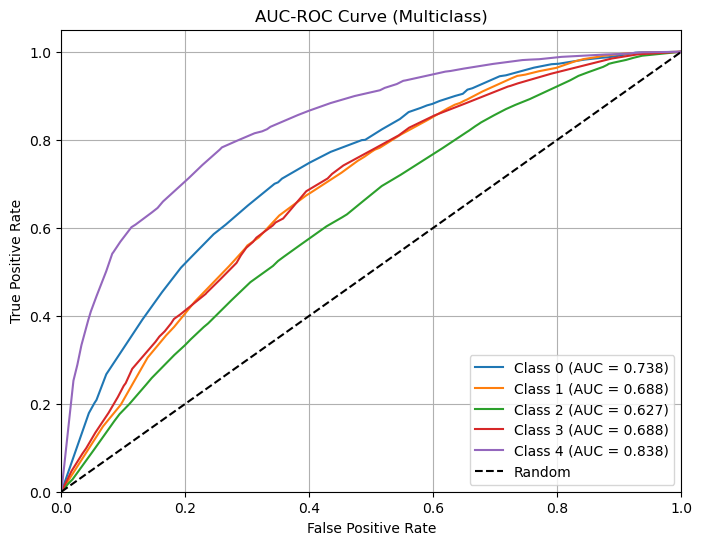

In [38]:
plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"],
    class_labels=metrics["labels"]
)

In [39]:
model.named_steps["classifier"].get_params()

{'ccp_alpha': 0.0007531425994893288,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': 79,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 7,
 'min_samples_split': 25,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}